# Logistic Regression

## About the algorithm

To begin with, one of the most simplest and widely used algorithms in use is logistic regression. It is one of the algorithms in the field of machine learning which is borrowed from statistics. It is the most prominent method for binary classification problems. The name logistic regression comes from the core function that is used in the algorithm which is the logistic function (it is also called sigmoid function) {cite}`brownlee_2020_logreg`.
Logistic regression models the probability of the dominant target class given the value of some independent variable. With some mathematical manipulations, it can be shown that log-odds is the linearly dependent on the independent variables. The minimization algorithm used to optimize the best coefficients for the given data is Maximum-Likelihood estimation. This is implemented using various optimization algorithms {cite}`brownlee_2020_logreg`.

In [20]:
# Import necessary packages
import pandas as pd
import numpy as np
import joblib
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 800
svg_renderer.height = 500
pio.renderers.default = "svg"

## Model without oversample data

At first, logistic regression will be used to model data in which the non-dominant class is not oversampled.

In [2]:
# Load the data
df = pd.read_csv('./../../data/engineered_data.csv')

In [3]:
# Drop the index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Before fitting any model to the data, it is necessary to split the data into training and testing set. The training data will contain 80% of the total observations while the testing data will consist of the remaining 20% of the complete data set.

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

The model will be constructed using the training data only.

To perform a preliminary check on the data, it will be prudent to train logistic regression with default parameters. This will allow us to gauge whether the data is separable or not.

On training with the most basic version of logistic regression i.e. logistic regression with default values, the following results can be obtained:

In [9]:
sm_logreg_obj = sm.Logit(y_train, sm.add_constant(X_train))
sm_logreg = sm_logreg_obj.fit()

Optimization terminated successfully.
         Current function value: 0.295182
         Iterations 10


In [10]:
print(sm_logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:                11889
Model:                          Logit   Df Residuals:                    11854
Method:                           MLE   Df Model:                           34
Date:                Sun, 04 Dec 2022   Pseudo R-squ.:                  0.5237
Time:                        09:08:06   Log-Likelihood:                -3509.4
converged:                       True   LL-Null:                       -7368.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3176        nan        nan        nan         nan         nan
goal                      -7.5488        nan        nan        nan         nan         nan
curr

The p-values for a lot of coefficients are not defined. This signifies that the model is not confident in the values of those coefficients and that there might be a possibility that the data is separable.

There are certain assumptions associated with logistic regression. One of them is that the data should not be completely separable. To deal with separability, penalized logistic regression is used.

The penalty that will be used is called "elastic net". This algorithm uses a weighted combination of L1 and L2 regularization. There exist parameters to set the proportion of the L1 and L2 regularizations. Also, to find the best hyper-parameters for the algorithm, a grid search will be performed with the following parameter ranges:

|Parameter|Description|Values|
|--|--|--|
|C|Parameter of trust for the training data|$10^{-4}$:$10^4$|
|max_iter|Maximum number of iterations to be performed|$100,200,500$|
|l1_ratio|Ratio of l1 in the elastic net|$0, 0.3, 0.6, 1$|

In [11]:
# Declare the logistic regression model
logreg_clf = LogisticRegression(penalty='elasticnet', fit_intercept=True, class_weight='balanced', solver='saga', random_state=42)

# Declare the grid paramters to be searched
logreg_params = dict(
    C = np.logspace(-4, 4, num=9),
    max_iter = [100, 200, 500],
    l1_ratio = [0, 0.3, 0.6, 1]
)

In [ ]:
# Declare the gridsearch object
grid_search = GridSearchCV(logreg_clf, logreg_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

### Inferencing

The best model is given by the parameters as follows:

In [13]:
# Get the best model parameters
print(f"Best score of {grid_search.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.8809883832925672 is achieved by using {'C': 10.0, 'l1_ratio': 0.3, 'max_iter': 500}


Since the model is now ready, it should be evaluated for its predictive power. To determine the predictive strength, the test data will be used. Using the coefficients obtained after training the logistic regression, they will be utilized to predict the probabilities of success for the observations present in the test data.

In [14]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

### Evaluation

The goodness of the model can be determined by using the Area Under the Curve of Receiver Operating Curve, also known AUC ROC. The closer the value of AUC ROC to 1, the better the model. 

In [15]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.8829888281528806


An AUC score of 0.88 is quite remarkable and it suggest that model is quite good in predicting whether a project on Kickstarter will be succecssful or not.

For further evaluations, the predicted probabilities need to be converted to specific binary outcomes of success or failure. In order to convert probabilities into binary outcomes, it is necessary to find a threshold above which the outcome will be termed as success and below which the outcome will be termed as failure.
The binary outcomes thus determined will be compared with the original outputs of the success of the projects.

In [16]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

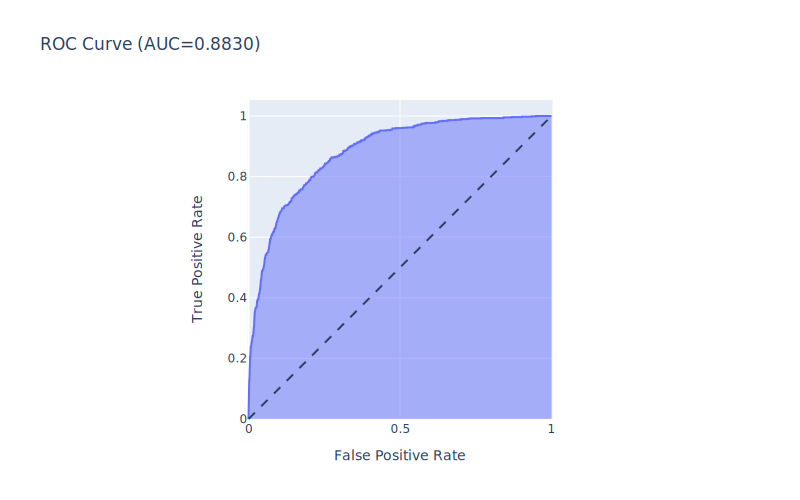

In [17]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [18]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

,fpr,tpr,threshold
434,0.204198,0.791334,0.479913
435,0.204676,0.791334,0.479765
436,0.204676,0.793615,0.479258
437,0.205153,0.793615,0.479249
438,0.205153,0.795895,0.479089
439,0.205630,0.795895,0.478822
440,0.205630,0.797035,0.478626
441,0.207538,0.797035,0.478218
442,0.207538,0.798176,0.478036
443,0.208969,0.798176,0.477853


The threshold value that can be used is 0.48. This value is not too far away from the default value of the threshold which is 0.5, hence the default value will be utilized to predict the final binary outcome.

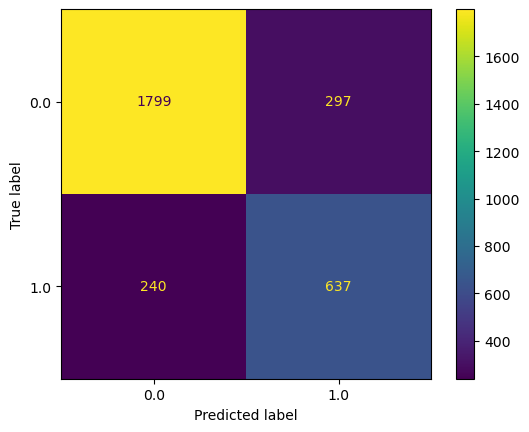

In [21]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_result, X_test, y_test)

In [23]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2096
         1.0       0.68      0.73      0.70       877

    accuracy                           0.82      2973
   macro avg       0.78      0.79      0.79      2973
weighted avg       0.82      0.82      0.82      2973



An F1 score of 0.82 is quite good and hence it can be concluded that the model can be used for the prediction of the success or failure of the Kickstarter project.

In [19]:
# Save the model
joblib.dump(grid_result, './../../data/models/logistic_regression.pkl')

['./../../data/models/logistic_regression.pkl']

## Model with oversample data

The logistic regression model may not work best when the data set is unbalanced. To overcome this shortcoming, undersampling or oversampling can be used to balance the data set. In this case, oversampling is performed on the non-dominant class.

In [24]:
# Load the data
df = pd.read_csv('./../../data/engineered_data_oversampled.csv')

In [25]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)

The same procedure will be followed as that followed for the data without oversampling. The data will be split into training and testing set with 80:20 ratio.

In [26]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

The model to be trained on the training data set in the following way:

In [27]:
# Declare the logistic regression model
logreg_clf = LogisticRegression(penalty='elasticnet', fit_intercept=True, class_weight='balanced', solver='saga')

# Declare the grid paramters to be searched
logreg_params = dict(
    C = np.logspace(-4, 4, num=9),
    max_iter = [100, 200, 500],
    l1_ratio = [0, 0.3, 0.6, 1]
)

In [ ]:
# Declare the gridsearch object
grid_search = GridSearchCV(logreg_clf, logreg_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

### Inferencing

The best model that is obtained with the following score and parameters:

In [29]:
# Get the best model parameters
print(f"Best score of {grid_result.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9032103824424617 is achieved by using {'C': 10000.0, 'l1_ratio': 1, 'max_iter': 500}


In [30]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

### Evaluation

For the comparison, AUC ROC score to be used is given by:

In [32]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9040847676364079


With the new oversampled data, there is slight improvement in the performance of the logistic regression algorithm.

The threshold can be found on the basic of the AUC ROC curve values.

In [31]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

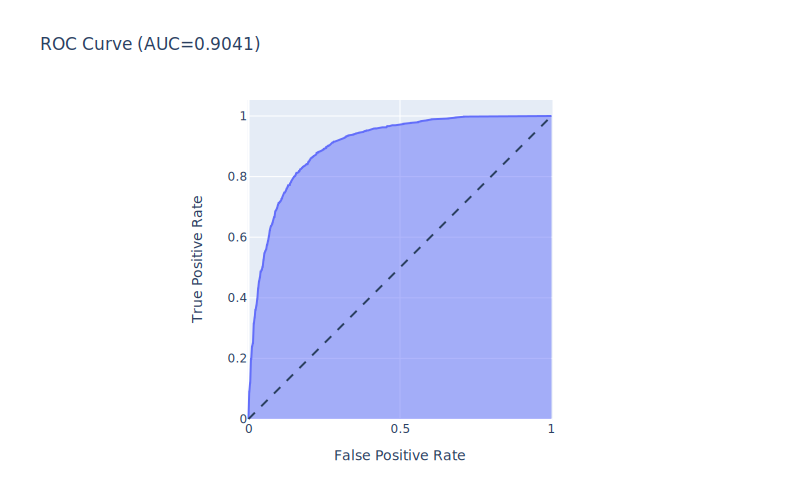

In [33]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [34]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

,fpr,tpr,threshold
480,0.143405,0.790743,0.488017
481,0.143885,0.790743,0.487851
482,0.143885,0.791728,0.487713
483,0.144844,0.791728,0.487675
484,0.144844,0.793698,0.487610
485,0.145324,0.793698,0.487528
486,0.145324,0.794190,0.487480
487,0.146283,0.794190,0.487367
488,0.146283,0.795175,0.487164
489,0.146763,0.795175,0.487124


For this data set also, it is the threshold value that can be utilized is close to 0.5 and hence the default value of 0.5 will be used for classification of records.

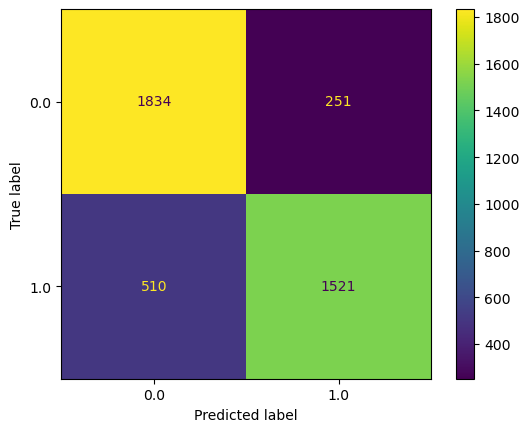

In [35]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_result, X_test, y_test)

In [36]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83      2085
         1.0       0.86      0.75      0.80      2031

    accuracy                           0.82      4116
   macro avg       0.82      0.81      0.81      4116
weighted avg       0.82      0.82      0.81      4116



The F1-score of the oversampled data is comparable with that of non-oversampled data but the other parameters such as precision and recall saw a marginal improvement. Hence it can be concluded that the model trained on oversampled data is better.

In [38]:
final_logreg_obj = sm.Logit(y_train, sm.add_constant(X_train))
final_logreg = final_logreg_obj.fit_regularized(method='l1', maxiter=500)

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning:

overflow encountered in exp

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2941108808353186
            Iterations: 252
            Function evaluations: 259
            Gradient evaluations: 252


In [39]:
print(final_logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:                16464
Model:                          Logit   Df Residuals:                    16426
Method:                           MLE   Df Model:                           37
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                  0.5757
Time:                        11:09:28   Log-Likelihood:                -4842.2
converged:                       True   LL-Null:                       -11412.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.5507      0.658      3.878      0.000       1.262       3.840
goal                      -7.5198      0.113    -66.443      0.000      -7.742      -7.298
curr

In [37]:
# Save the model
joblib.dump(grid_result, './../../data/models/logistic_regression_oversample.pkl')

['./../../data/models/logistic_regression_oversample.pkl']